<a href="https://colab.research.google.com/github/krmiddlebrook/intro_to_graphing_in_python/blob/master/notebooks/machine_learning/lesson%202%20-%20logistic%20regression/Classification_Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification: Logistic Regression
In [lesson 1 - linear regression](https://github.com/krmiddlebrook/intro_to_graphing_in_python/tree/master/notebooks/machine_learning/lesson%201%20-%20linear%20regression), we learned about linear regression and how it can be used to construct a model to predict a numeric value (i.e., how powerful a Pokemon is given their x values/attributes). In this lesson, we will learn how to solve classification problems using logistic regression. Different from linear regression, logistic regression is a classification algorithm used to assign observations to a discrete set of classes. Some examples of classification problems are email spam or not spam, legendary Pokemon or not, tumor malignant (harmful) or benign (not harmful). We can use logistic regression to transform input data into a probability value to predict the class the data belongs to.

![Linear vs. Logistic Regression | Source: Datacamp](https://miro.medium.com/max/1400/1*dm6ZaX5fuSmuVvM4Ds-vcg.jpeg)

In this notebook, we will learn logistic regression by build a logistic regression model to predict whether an app on the Google Play Store is free or not. The rest of this notebook is organized as follows:
1. Introduction to logistic regression
2. Load the [Google Play Store dataset](https://www.kaggle.com/lava18/google-play-store-apps)
3. Explore the dataset and prepare data for our model
4. Build a logistic regression model
5. Measure the quality of the model
6. Draw conclusions



## Introduction to logistic regression

Logistic regression is a popular classification algorithm in machine learning. In short, logistic regression uses the *sigmoid activation function* (see figure below) to map the input data to a probability value between 0 and 1. In general, the probability threshold is 0.5. For example, if we were predicting whether a pokemon was legendary or not, and the output of the sigmoid function was 0.7 based on the input values of a specific Pokemon, then we would classify that Pokemon as legendary. However, the probability threshold may be lower or higher than 0.5 depending on the task. Below is the graph of a sigmoid function with the equation of the function on top. 

![sigmoid activation function](https://miro.medium.com/max/1280/1*OUOB_YF41M-O4GgZH_F2rw.png)

When we were doing linear regression, the formula was $y=ax+b$. The formula for logistic regression is very similar: $$
y = \sigma(ax+b)
$$ where $\sigma$ represents the sigmoid activation function. The only difference between the formula for logistic regression is that the sigmoid activation function is wrapped around the $ax+b$ terms. Don't worry to much if this doesn't make too much sense yet, it might help to see logistic regression in action.

## Load the Google Play Store dataset

In [87]:
import pandas as pd
import numpy as np

data_url = 'https://raw.githubusercontent.com/krmiddlebrook/intro_to_graphing_in_python/master/datasets/googleplaystore.csv'
apps_data = pd.read_csv(data_url)
apps_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


# Explore the dataset and prepare it for our model
In this section we will focus on identifying the x variables/features that we will use in our logistic regression model to predict whether the app was free or not (i.e., the "Type" column). 

In [88]:
# check the column types and get basic info
apps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [89]:
# convert the Size column to an integer type using these provided functions

#scaling and cleaning "Size" (of app) column
def change_size(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None

apps_data["Size"] = apps_data["Size"].map(change_size)

#filling Size which had NA
apps_data.Size.fillna(method = 'ffill', inplace = True)
apps_data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [90]:
# clean and convert the "Installs" column to int
apps_data['Installs'] = apps_data['Installs'].str.replace(',', '')
apps_data['Installs'] = apps_data['Installs'].str.replace('+', '')

# remove mislabeled row
apps_data = apps_data.loc[~apps_data['Installs'].str.contains('\D+'), :].reset_index(drop=True)

apps_data['Installs'] = apps_data['Installs'].astype(int)

# clean and convert the "Reviews" column to int
# fix mislabeled row in the "Reviews" column
# apps_data.loc[apps_data.Reviews.str.contains('M'), 'Reviews'] = int(apps_data.loc[apps_data.Reviews.str.contains('M'), 'Reviews'].values.tolist()[0][:-1])*1000000
apps_data['Reviews'] = apps_data['Reviews'].astype('int')

# remove price column so we don't cheat
apps_data = apps_data.drop(columns=['Price'])

# remove columns we won't be using in our analysis
apps_data.head()


,App,Category,Rating,Reviews,Size,Installs,Type,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19000000.0,10000,Free,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14000000.0,500000,Free,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8700000.0,5000000,Free,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25000000.0,50000000,Free,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2800000.0,100000,Free,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [91]:
apps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10840 entries, 0 to 10839
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10840 non-null  object 
 1   Category        10840 non-null  object 
 2   Rating          9366 non-null   float64
 3   Reviews         10840 non-null  int64  
 4   Size            10840 non-null  float64
 5   Installs        10840 non-null  int64  
 6   Type            10839 non-null  object 
 7   Content Rating  10840 non-null  object 
 8   Genres          10840 non-null  object 
 9   Last Updated    10840 non-null  object 
 10  Current Ver     10832 non-null  object 
 11  Android Ver     10838 non-null  object 
dtypes: float64(2), int64(2), object(8)
memory usage: 1016.4+ KB


In [92]:
# converting non-numeric columns to numeric columns using "one-hot encoding"
catgry=pd.get_dummies(apps_data['Category'],prefix='catg',drop_first=True)
cr=pd.get_dummies(apps_data['Content Rating'],prefix='cr',drop_first=True)
frames=[apps_data,catgry,cr]
apps_data=pd.concat(frames,axis=1)
apps_data = apps_data.drop(['Category', 'Content Rating'], axis=1)
apps_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10840 entries, 0 to 10839
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   App                       10840 non-null  object 
 1   Rating                    9366 non-null   float64
 2   Reviews                   10840 non-null  int64  
 3   Size                      10840 non-null  float64
 4   Installs                  10840 non-null  int64  
 5   Type                      10839 non-null  object 
 6   Genres                    10840 non-null  object 
 7   Last Updated              10840 non-null  object 
 8   Current Ver               10832 non-null  object 
 9   Android Ver               10838 non-null  object 
 10  catg_AUTO_AND_VEHICLES    10840 non-null  uint8  
 11  catg_BEAUTY               10840 non-null  uint8  
 12  catg_BOOKS_AND_REFERENCE  10840 non-null  uint8  
 13  catg_BUSINESS             10840 non-null  uint8  
 14  catg_C

In [93]:
# select the x and y variables for the model
X = apps_data.drop(['App', 'Genres', 'Last Updated', 'Current Ver', 'Android Ver'], axis=1)

# drop rows with missing values
X = X.dropna()

# convert "Type" column to int before creating y variable
def convert_type_to_int(type):
  if type == 'Free':
    return 0
  else:
    return 1

X['Type'] = X['Type'].map(convert_type_to_int)
y = X['Type'].values

# drop the Type column from the X variables
X = X.drop(['Type'], axis=1)
print('X shape', X.shape)
print('y shape', y.shape)

X shape (9366, 41)
y shape (9366,)


In [94]:
# split the dataset into a train and test set since we want to see how well it
# performs on unseen data. Here we use 80% of the data for training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)
print('X_train shape', X_train.shape, 'X_test shape', X_test.shape)

X_train shape (7492, 41) X_test shape (1874, 41)


In [95]:
# if you run into an error, run the train test split again and make sure the training data
# has two unique values: 0 and 1 
np.unique(y_train)

array([0, 1])

## Build a logistic regression model

In [96]:
from sklearn.linear_model import LogisticRegression

# initialize the model
model = LogisticRegression(random_state=0)

# train/fit the model using the training data
model.fit(X_train, y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Measure the quality of the model

In [113]:
from sklearn import metrics

# make predictions on the test data
preds = model.predict(X_test)

# measure the accuracy
model_acc = metrics.accuracy_score(y_test, preds)
print(f'logistic regression model accuracy: {round(model_acc*100, 2)}%')

logistic regression model accuracy: 93.12%


Wow! Our logistic regression model fit the Google Play Store data pretty well, correctly predicting whether an app was free or not about 93.12% of the time. However, the distribution of free apps to non-free apps is not balanced, so we should check the confusion matrix to make sure the model wasn't just predicting every app as "free" since there are more of them than "paid" apps. A confusion matrix indicates the number of correct predictions and incorrect predictions for each class. It is particularly useful whenever the data has an imbalanced representation of the classes. The diagonals of a confusion matrix indicate the correct predictions for each class, while the cross-diagonal indicates misclassified predictions. Below is an example of a binary classification confusion matrix (i.e., there are only two classes)
![confusion matrix](https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png) 

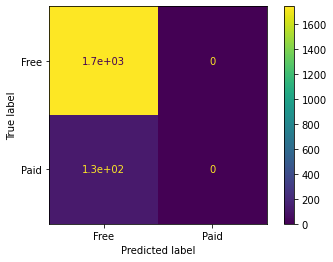

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

labels = ['Free', 'Paid']
metrics.plot_confusion_matrix(model, X_test, y_test, display_labels=labels, normalize=None) 
plt.show();

Woah! Despite the high accuracy score of the model, it looks like the model is classifying every unseen app as a "free" app (wouldn't that be nice). Let's take a look at a more comprehensive set of evaluation metrics: accuracy, precision, and recall. Precision indicates the model's ability ability to return only relevant instances. While recall indicates the model's ability to identify all relevant instances; and depending on our data we may want a higher precision score or vice versa. But if this sounds confusing right now don't worry, these metrics will become more clear as you work through logistic regression challenges. If your curious, here is an in-depth discussion of these metrics: [Beyond Accuracy: Precision and Recall](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c). 

In [120]:
print("Accuracy:", metrics.accuracy_score(y_test, preds))
print("Precision:", metrics.precision_score(y_test, preds, zero_division=True))
print("Recall:" ,metrics.recall_score(y_test, preds, zero_division=True))

Accuracy: 0.9311632870864461
Precision: 1.0
Recall: 0.0


# Draw conclusions

It looks like our logistic regression classification model fit the data pretty well because it correctly predicted whether an app was free or not about 93.12% of the time on the test dataset. However, since our dataset is heavily imbalanced (i.e., skewed), with many more "free" apps than "paid" apps, we checked the precision and recall scores of the model too. The precision score is a perfect 100%, meaning our model identifies "free" apps 100% of the time. On the other hand, the recall score was 0%, meaning our model is not good at identifying "paid" apps. 